# Code for normal CNN

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
import joblib

# Step 1: Load CSV file
data = pd.read_csv('/content/FINALLY_PLANK.csv')

# Step 2: Separate keypoints and labels
keypoints = data.iloc[:, 1:89].values  # Skip the first column (frame name) and take the next 88 columns
correct_label = data['pose-label'].values  # Binary labels: 0 (incorrect), 1 (correct)
error_type = data['error-label'].fillna('None').values  # Error types: None, Too-high-plank, Too-low-plank

# Step 3: Normalize keypoints (Min-Max Scaling)
scaler = MinMaxScaler()
keypoints = scaler.fit_transform(keypoints)

# Save the scaler for later use in backend
joblib.dump(scaler, '/content/scaler.pkl')

# Step 4: Reshape keypoints to (88, 1) for CNN input
keypoints = keypoints.reshape(-1, 88, 1)

# Step 5: Convert Error Type labels
encoder = LabelEncoder()
error_type_encoded = encoder.fit_transform(error_type)  # Encode error types as integers
error_type_categorical = to_categorical(error_type_encoded)  # One-hot encode for categorical model

# Save the label encoder for backend use
joblib.dump(encoder, '/content/encoder.pkl')

# Step 6: Split data into training and testing sets
X_train, X_test, y_train_correct, y_test_correct, y_train_error, y_test_error = train_test_split(
    keypoints, correct_label, error_type_categorical, test_size=0.2, random_state=42
)

# Print data shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train_correct shape: {y_train_correct.shape}")
print(f"y_train_error shape: {y_train_error.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_correct shape: {y_test_correct.shape}")
print(f"y_test_error shape: {y_test_error.shape}")


X_train shape: (92, 88, 1)
y_train_correct shape: (92,)
y_train_error shape: (92, 3)
X_test shape: (24, 88, 1)
y_test_correct shape: (24,)
y_test_error shape: (24, 3)


CNN

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_1 = build_cnn_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_1 = model_1.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_1.save('/content/cnn_pose-label.keras')

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4796 - loss: 0.6865 - val_accuracy: 0.6250 - val_loss: 0.6437
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6644 - loss: 0.6028 - val_accuracy: 0.6250 - val_loss: 0.5923
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6386 - loss: 0.5860 - val_accuracy: 0.6667 - val_loss: 0.5440
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8327 - loss: 0.5243 - val_accuracy: 0.7083 - val_loss: 0.5209
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7009 - loss: 0.5174 - val_accuracy: 0.7917 - val_loss: 0.4988
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6861 - loss: 0.5259 - val_accuracy: 0.7917 - val_loss: 0.4836
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6994 - loss: 0.4876 - val_accuracy: 0.7917 - val_loss: 0.4876
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7298 - loss: 0.4873 - val_accuracy: 0.7917 - 

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_1 = model_1.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_1 = (y_pred_model_1 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_1)

# Precision
precision = precision_score(y_test_correct, y_pred_model_1)

# Recall
recall = recall_score(y_test_correct, y_pred_model_1)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_1)

print(f"Model CNN Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Model CNN Evaluation:
Accuracy: 0.7916666666666666
Precision: 0.75
Recall: 0.6666666666666666
F1 Score: 0.7058823529411765


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Multi-class classification output (3 classes)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_2 = build_cnn_error_classification()

history_2 = model_2.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_2.save('/content/cnn_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (59, 3)
Shape of y_test_error_incorrect before one-hot encoding: (15, 3)
Shape of y_train_error_incorrect after one-hot encoding: (59, 3)
Shape of y_test_error_incorrect after one-hot encoding: (15, 3)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.5056 - loss: 1.0152 - val_accuracy: 0.4667 - val_loss: 0.7871
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5907 - loss: 0.7779 - val_accuracy: 0.4000 - val_loss: 0.7265
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4735 - loss: 0.7066 - val_accuracy: 0.6000 - val_loss: 0.6446
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5630 - loss: 0.6645 - val_accuracy: 0.7333 - val_loss: 0.6380
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6916 - loss: 0.6271 - val_accuracy: 0.5333 - val_loss: 0.6595
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7350 - loss: 0.6046 - val_accuracy: 0.7333 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


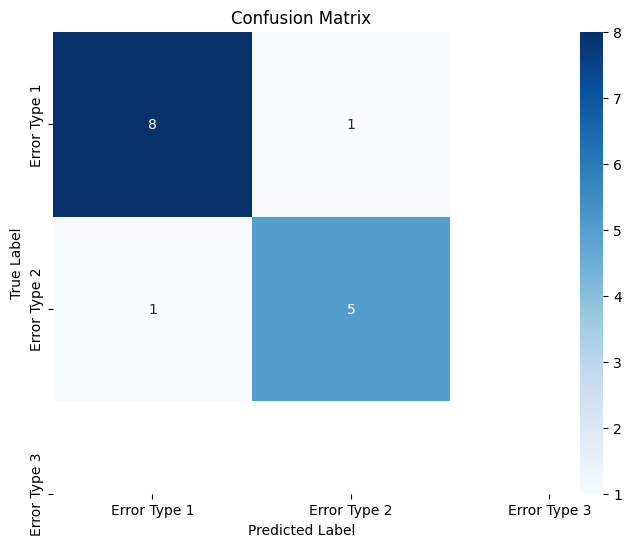

Model CNN Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.8888888888888888
F1 Score for Error Type 3: 0.8333333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_2 = model_2.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_2 = np.argmax(y_pred_model_2, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_2)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

CNN with Attention

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_with_attention_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_3 = build_cnn_with_attention_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_3 = model_3.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_3.save('/content/cnn-with-attention_pose-label.keras')

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.4507 - loss: 0.6851 - val_accuracy: 0.6250 - val_loss: 0.6687
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6332 - loss: 0.6637 - val_accuracy: 0.6250 - val_loss: 0.6587
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6449 - loss: 0.6458 - val_accuracy: 0.6250 - val_loss: 0.6507
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5941 - loss: 0.6715 - val_accuracy: 0.6250 - val_loss: 0.6427
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6214 - loss: 0.6447 - val_accuracy: 0.6250 - val_loss: 0.6416
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6332 - loss: 0.6347 - val_accuracy: 0.6250 - val_loss: 0.6314
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6332 - loss: 0.6283 - val_accuracy: 0.6250 - val_loss: 0.6139
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6566 - loss: 0.5997 - val_accuracy: 0.6250 - 

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_3 = model_3.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_3 = (y_pred_model_3 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_3)

# Precision
precision = precision_score(y_test_correct, y_pred_model_3)

# Recall
recall = recall_score(y_test_correct, y_pred_model_3)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_3)

print(f"Model CNN with Attention Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Model CNN with Attention Evaluation:
Accuracy: 0.7083333333333334
Precision: 0.625
Recall: 0.5555555555555556
F1 Score: 0.5882352941176471


In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_with_attention_error_classification():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_4 = build_cnn_error_classification()

history_4 = model_4.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_4.save('/content/cnn-with-attention_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (59, 3)
Shape of y_test_error_incorrect before one-hot encoding: (15, 3)
Shape of y_train_error_incorrect after one-hot encoding: (59, 3)
Shape of y_test_error_incorrect after one-hot encoding: (15, 3)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.3076 - loss: 1.0646 - val_accuracy: 0.6000 - val_loss: 0.7791
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6255 - loss: 0.7594 - val_accuracy: 0.6000 - val_loss: 0.6821
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4944 - loss: 0.7040 - val_accuracy: 0.6667 - val_loss: 0.6635
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7029 - loss: 0.6717 - val_accuracy: 0.4000 - val_loss: 0.6939
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5178 - loss: 0.6640 - val_accuracy: 0.6000 - val_loss: 0.6648
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6785 - loss: 0.6193 - val_accuracy: 0.7333 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


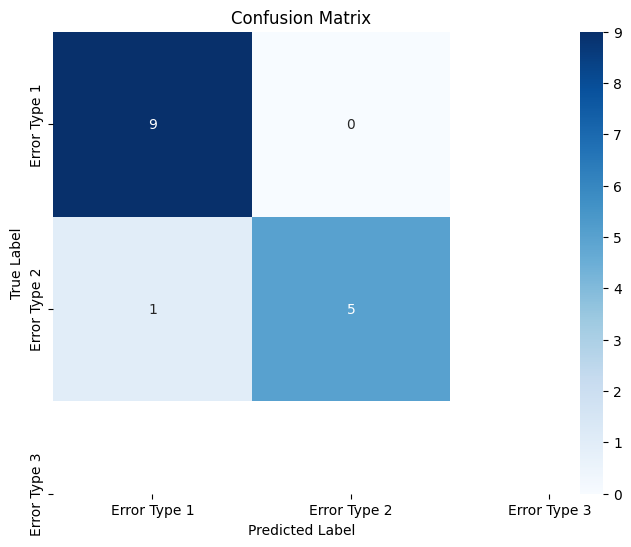

Model CNN with Attention Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.9473684210526315
F1 Score for Error Type 3: 0.9090909090909091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_4 = model_4.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_4 = np.argmax(y_pred_model_4, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_4)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN with Attention Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

VGG

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_5 = build_vgg_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_5 = model_5.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_5.save('/content/vgg_pose-label.keras')

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.6527 - loss: 0.6808 - val_accuracy: 0.6250 - val_loss: 0.6624
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6449 - loss: 0.6381 - val_accuracy: 0.6250 - val_loss: 0.6397
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6761 - loss: 0.6123 - val_accuracy: 0.6250 - val_loss: 0.6173
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6253 - loss: 0.6116 - val_accuracy: 0.6250 - val_loss: 0.5836
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6722 - loss: 0.5523 - val_accuracy: 0.6667 - val_loss: 0.5512
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7882 - loss: 0.5211 - val_accuracy: 0.7083 - val_loss: 0.5198
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6720 - loss: 0.5236 - val_accuracy: 0.7083 - val_loss: 0.5165
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7048 - loss: 0.4938 - val_accuracy: 0.7083 - 

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_5 = model_5.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_5 = (y_pred_model_5 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_5)

# Precision
precision = precision_score(y_test_correct, y_pred_model_5)

# Recall
recall = recall_score(y_test_correct, y_pred_model_5)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_5)

print(f"Model VGG Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Model VGG Evaluation:
Accuracy: 0.7083333333333334
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421


In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_vgg_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_6 = build_vgg_error_classification()

history_6 = model_6.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_6.save('/content/vgg_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (59, 3)
Shape of y_test_error_incorrect before one-hot encoding: (15, 3)
Shape of y_train_error_incorrect after one-hot encoding: (59, 3)
Shape of y_test_error_incorrect after one-hot encoding: (15, 3)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.2007 - loss: 1.0627 - val_accuracy: 0.4000 - val_loss: 0.8711
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5187 - loss: 0.8275 - val_accuracy: 0.4000 - val_loss: 0.7232
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5056 - loss: 0.6962 - val_accuracy: 0.6000 - val_loss: 0.6664
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6133 - loss: 0.6852 - val_accuracy: 0.4000 - val_loss: 0.7417
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5056 - loss: 0.6784 - val_accuracy: 0.6667 - val_loss: 0.6641
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5595 - loss: 0.6621 - val_accuracy: 0.6667 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


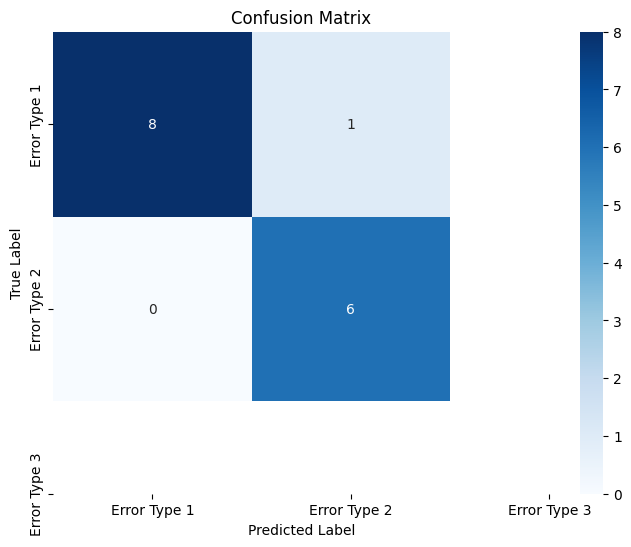

Model VGG Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.9411764705882353
F1 Score for Error Type 3: 0.9230769230769231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_6 = model_6.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_6 = np.argmax(y_pred_model_6, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_6)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[2], average='micro')  # Error Type 3

print(f"Model VGG Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

Transformer

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 1: Build the model
model_7 = build_transformer_correct_incorrect()

# Step 2: Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 3: Train the model
history_7 = model_7.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

# Save the trained model
model_7.save('/content/transformer_pose-label.keras')


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 333ms/step - accuracy: 0.4586 - loss: 0.7343 - val_accuracy: 0.6250 - val_loss: 0.7101
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6175 - loss: 0.7138 - val_accuracy: 0.6250 - val_loss: 0.6597
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6292 - loss: 0.6646 - val_accuracy: 0.6250 - val_loss: 0.6607
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6878 - loss: 0.6473 - val_accuracy: 0.6250 - val_loss: 0.6597
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6371 - loss: 0.6553 - val_accuracy: 0.6250 - val_loss: 0.6534
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6253 - loss: 0.6543 - val_accuracy: 0.6250 - val_loss: 0.6497
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6371 - loss: 0.6463 - val_accuracy: 0.6250 - val_loss: 0.6478
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6253 - loss: 0.6521 - val_accuracy: 0.6250 -

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_7 = model_7.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_7 = (y_pred_model_7 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_7)

# Precision
precision = precision_score(y_test_correct, y_pred_model_7)

# Recall
recall = recall_score(y_test_correct, y_pred_model_7)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_7)

print(f"Model Transformer Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Model Transformer Evaluation:
Accuracy: 0.7916666666666666
Precision: 1.0
Recall: 0.4444444444444444
F1 Score: 0.6153846153846154


In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_error_classification():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)  # Adjust to 3 output classes

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_8 = build_transformer_error_classification()

history_8 = model_8.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_8.save('/content/transformer_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (59, 3)
Shape of y_test_error_incorrect before one-hot encoding: (15, 3)
Shape of y_train_error_incorrect after one-hot encoding: (59, 3)
Shape of y_test_error_incorrect after one-hot encoding: (15, 3)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.1695 - loss: 1.2029 - val_accuracy: 0.6000 - val_loss: 0.7476
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4839 - loss: 0.8033 - val_accuracy: 0.4000 - val_loss: 0.7383
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5056 - loss: 0.7176 - val_accuracy: 0.4000 - val_loss: 0.7542
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5265 - loss: 0.7022 - val_accuracy: 0.6000 - val_loss: 0.6914
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4631 - loss: 0.6974 - val_accuracy: 0.6000 - val_loss: 0.6776
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4839 - loss: 0.7087 - val_accuracy: 0.6000 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


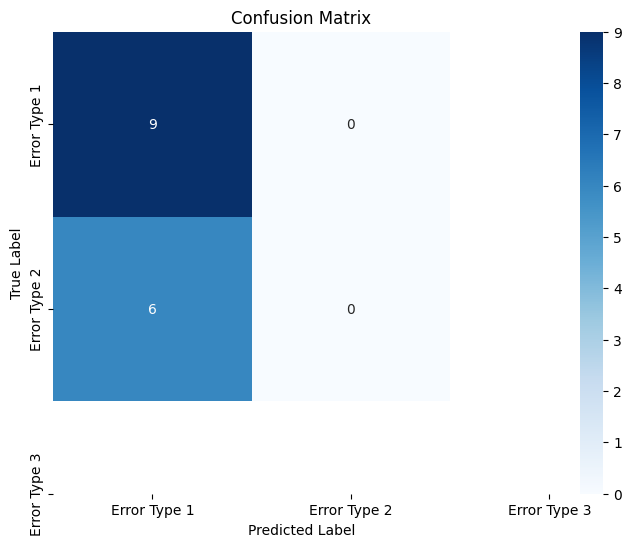

Model Transformer Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.75
F1 Score for Error Type 3: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_8 = model_8.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_8 = np.argmax(y_pred_model_8, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_8)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[2], average='micro')  # Error Type 3

print(f"Model Transformer Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")